## <center>SVM Classification</center>

### Load the Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import re

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [54]:
from pandas.errors import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore",category=(SettingWithCopyWarning))
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load the feature data file

In [3]:
# Load file with user summaries
filename = os.path.join(os.path.dirname(__name__), "DataFiles\\feature_dataset.tsv")
df = pd.read_csv(filename,delimiter='\t',low_memory=False)
df.head(2)

,summary,film_id,summary_id,sentiment_score,st_embeddings
0,"Two detectives, a rookie and a veteran, hunt a...",tt0114369,1,-0.8074,"tensor([[-4.0078e-02, 8.0701e-02, -2.9989e-01..."
1,A film about two homicide detectives' (Morgan ...,tt0114369,2,-0.9455,"tensor([[-2.0292e-01, -1.9715e-01, -6.2847e-02..."


### Select the labelled data

In [6]:
# read the summary data
filename = os.path.join(os.path.dirname(__name__), "DataFiles\\target_labels.csv")
target = pd.read_csv(filename,delimiter=',',low_memory=False)

In [7]:
labelled_movie_list = list(target.film_id.unique())

#### Create unlabelled dataset

In [33]:
unlabelled_df = df[~df['film_id'].isin(labelled_movie_list)]

#### Merge feature data with target labels

In [9]:
# individual summaries
single_summary_df = df[df['film_id'].isin(labelled_movie_list)]

In [10]:
single_df = pd.merge(single_summary_df, target, how="left", on=["film_id"])

### Pre-process data

In [11]:
single_df.head()

,summary,film_id,summary_id,sentiment_score,st_embeddings,manual_label
0,"Two detectives, a rookie and a veteran, hunt a...",tt0114369,1,-0.8074,"tensor([[-4.0078e-02, 8.0701e-02, -2.9989e-01...",crime and corruption
1,A film about two homicide detectives' (Morgan ...,tt0114369,2,-0.9455,"tensor([[-2.0292e-01, -1.9715e-01, -6.2847e-02...",crime and corruption
2,"Taking place in a nameless city, Se7en follows...",tt0114369,3,-0.9280,"tensor([[ 3.7507e-03, -1.4317e-02, 4.7032e-02...",crime and corruption
3,"Two police detectives - one, Somerset, about t...",tt0114369,4,-0.9638,"tensor([[-2.6848e-01, -1.5027e-01, -2.2207e-01...",crime and corruption
4,"Two detectives, one about to leave and one ent...",tt0114369,5,-0.9153,"tensor([[-1.5068e-01, -2.7328e-02, -3.2119e-01...",crime and corruption


#### Pre-process dataset
lowercase the target labels and strip any extra spaces

In [12]:

single_df['manual_label'] = single_df['manual_label'].progress_apply(lambda x: (x.lower().strip()))

  0%|          | 0/3501 [00:00<?, ?it/s]

In [14]:
X = single_df.drop(['manual_label','summary_id', 'summary','film_id',], axis=1)
y = single_df['manual_label']

In [16]:
single_df.manual_label.value_counts()

others                           1859
socioeconomic inequality          331
crime and corruption              298
war or revolution                 170
racism or discrimination          144
feminism                          126
health and disease                121
environmental issues               92
drugs and alcoholism               90
political issues                   78
lgbtq                              78
disability                         70
immigration or refugee crisis      44
Name: manual_label, dtype: int64

### Data split into train and test

In [17]:
from sklearn.model_selection import train_test_split

# Splitting the labeled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")

X_train.shape: (2800, 2)
X_test.shape: (701, 2)


### Feature creation
Convert string embeddings into tensor normalized embeddings

In [19]:
# convert strings into normalized embeddings
X_train['st_embeddings'] = X_train.st_embeddings.progress_apply(lambda x: F.normalize(eval("torch." + x), p=2, dim=1))
X_test['st_embeddings'] = X_test.st_embeddings.progress_apply(lambda x: F.normalize(eval("torch." + x), p=2, dim=1))
X_train.info()

  0%|          | 0/2800 [00:00<?, ?it/s]

  0%|          | 0/701 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 1125 to 756
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiment_score  2800 non-null   float64
 1   st_embeddings    2800 non-null   object 
dtypes: float64(1), object(1)
memory usage: 65.6+ KB


 Normalize sentiment score between [0,1]

In [20]:
# Normalize sentiment score between [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
sentiment_train_scaled = scaler.fit_transform(X_train['sentiment_score'].to_numpy().reshape(-1, 1))
sentiment_test_scaled = scaler.fit_transform(X_test['sentiment_score'].to_numpy().reshape(-1, 1))

In [21]:
# stack embeddings as np.array
X_train_embeddings = np.vstack(X_train['st_embeddings'].values)
X_test_embeddings = np.vstack(X_test['st_embeddings'].values)
X_train_embeddings.shape

(2800, 384)

#### Create a feature set with embeddings and sentiment scores

In [22]:

X_train_features = np.column_stack((X_train_embeddings, sentiment_train_scaled))
X_test_features = np.column_stack((X_test_embeddings, sentiment_test_scaled))

### Correct imbalance using class weights

In [23]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes = np.unique(y), y = y)
class_weights

array([0.90371709, 3.84725275, 2.99230769, 2.92725753, 2.13736264,
       2.22568341, 6.12062937, 3.45266272, 0.14486697, 3.45266272,
       1.87019231, 0.81361841, 1.5841629 ])

In [24]:
class_weight_dict = dict(zip(np.unique(y), class_weights))
class_weight_dict

{'crime and corruption': 0.9037170882808466,
 'disability': 3.8472527472527474,
 'drugs and alcoholism': 2.9923076923076923,
 'environmental issues': 2.927257525083612,
 'feminism': 2.1373626373626373,
 'health and disease': 2.2256834075015894,
 'immigration or refugee crisis': 6.120629370629371,
 'lgbtq': 3.4526627218934913,
 'others': 0.14486696735217444,
 'political issues': 3.4526627218934913,
 'racism or discrimination': 1.8701923076923077,
 'socioeconomic inequality': 0.8136184057634208,
 'war or revolution': 1.5841628959276017}

### Base-line accuracy

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [26]:
# Features = embeddings + sentiment scores
dc1 = DummyClassifier(strategy = 'most_frequent')
dc1.fit(X_train_features, y_train)

acc1 = accuracy_score(y_train, dc1.predict(X_train_features))

print(f'Baseline accuracy = {acc1:.3f}')

Baseline accuracy = 0.531


### check with PCA (only embeddings)

In [27]:
from sklearn.decomposition import PCA

pca1 = PCA()
pca1.fit(X_train_features)

PCA()

385


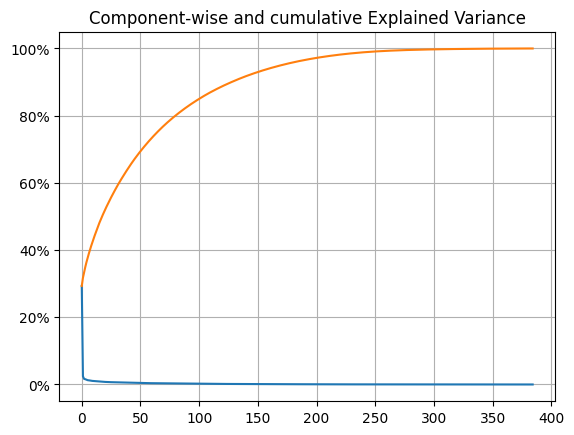

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
tot_var = np.array(pca1.explained_variance_ratio_)
print(len(tot_var))

plt.plot(range(385), pca1.explained_variance_ratio_)
plt.plot(range(385), np.cumsum(pca1.explained_variance_ratio_))
plt.title("Component-wise and cumulative Explained Variance")
plt.grid()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

In [29]:
# Dimensionality Reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # Adjust the number of components based on explained variance
X_train_reduced = pca.fit_transform(X_train_embeddings)
X_test_reduced = pca.transform(X_test_embeddings)

### Apply SVM 

In [30]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

### Nested cross validation approach

### SVC models hyper parameters defined

In [31]:
param_C_values = [1, 10, 100, 1000]
param_gamma_values = [0.1, 0.01, 0.001, 0.0001]

param_grid = [
              { 'kernel' : ['linear'],
               'class_weight' : [None, class_weight_dict],
               'C' : param_C_values
               },
              { 'kernel' : ['poly'], 
               'C' : param_C_values, 
               'class_weight' : [None, class_weight_dict],
               'degree' : [2, 3, 4, 5, 6], 
               'gamma' : param_gamma_values
               },
              { 'kernel' : ['rbf'],
               'C' : param_C_values,
               'class_weight' : [None, class_weight_dict],
               'gamma' : param_gamma_values
               }
]

### SVC models with features - embeddings + sentiment score without PCA

In [60]:
from sklearn.model_selection import cross_val_score

inner_cv_folds = StratifiedKFold(n_splits = 5, shuffle = True)
outer_cv_folds = StratifiedKFold(n_splits = 5, shuffle = True)

# inner loop for parameter search
gs = GridSearchCV(estimator = SVC(),
                  param_grid = param_grid,
                  cv = inner_cv_folds,
                  scoring = 'accuracy',
                  verbose = 0)

# outer loop for accuracy scoring
scores = cross_val_score(gs, X = X_train_features, y = y_train, cv = outer_cv_folds, verbose = 99)


[CV] START .....................................................................
[CV] END ................................ score: (test=0.738) total time=16.3min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed: 16.3min
[CV] START .....................................................................
[CV] END ................................ score: (test=0.735) total time=17.5min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed: 33.8min
[CV] START .....................................................................
[CV] END ................................ score: (test=0.674) total time=17.9min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 51.6min
[CV] START .....................................................................
[CV] END ................................ score: (test=0.717) total time=17.6min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed: 69.3min
[CV] START .....................................................................
[CV] END ..................

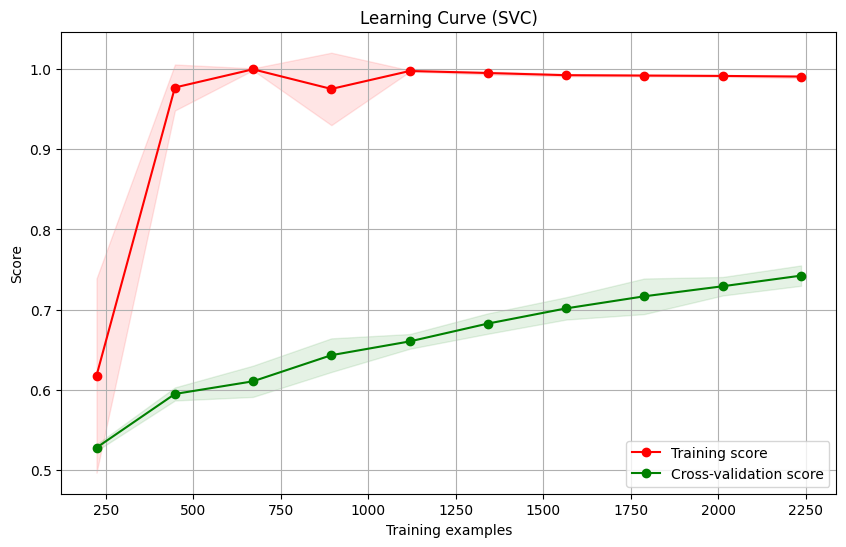

In [61]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    gs, X=X_train_features, y=y_train, cv=outer_cv_folds, 
    scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), verbose=0
)

# Calculate mean and standard deviation for plotting
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve (SVC)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

# Plot cross-validation scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

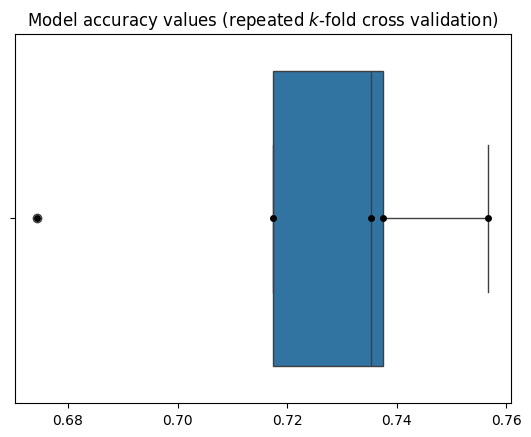

In [62]:
sns.boxplot(x = scores)
sns.swarmplot(x = scores, color = 'black')
plt.title('Model accuracy values (repeated $k$-fold cross validation)')
plt.show()

In [63]:
print(f'Mean score using nested cross-validation: {scores.mean():.3f} +/- {scores.std():.3f}')

Mean score using nested cross-validation: 0.724 +/- 0.028


Note that the aim of the above nested cross-validation is solely to get an unbiased estimate of the accuracy of the SVM model. It's not to get an unbiased accuracy estimate **and** also the best model. See the links given earlier for the reasons why it's not a good idea to use the best model while estimating a model's accuracy.

In [64]:
cv_folds = StratifiedKFold(n_splits = 5, shuffle = True)

gs = GridSearchCV(estimator = SVC(),
                  param_grid = param_grid,
                  cv = cv_folds,
                  scoring = 'accuracy',
                  return_train_score = True,
                  refit = True,
                  verbose = 3)

#### Running model selection on the training set:

In [65]:
gs.fit(X_train_features, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END C=1, class_weight=None, kernel=linear;, score=(train=0.586, test=0.555) total time=   0.7s
[CV 2/5] END C=1, class_weight=None, kernel=linear;, score=(train=0.581, test=0.560) total time=   0.6s
[CV 3/5] END C=1, class_weight=None, kernel=linear;, score=(train=0.568, test=0.547) total time=   0.6s
[CV 4/5] END C=1, class_weight=None, kernel=linear;, score=(train=0.580, test=0.555) total time=   0.6s
[CV 5/5] END C=1, class_weight=None, kernel=linear;, score=(train=0.576, test=0.562) total time=   0.6s
[CV 1/5] END C=1, class_weight={'crime and corruption': 0.9024264326277749, 'disability': 3.841758241758242, 'drugs and alcoholism': 2.988034188034188, 'environmental issues': 2.95519864750634, 'feminism': 2.1343101343101343, 'health and disease': 2.2225047679593133, 'immigration or refugee crisis': 6.111888111888112, 'lgbtq': 3.447731755424063, 'others': 0.14481587341038069, 'political issues': 3.492507492507492

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None,
                                           {'crime and corruption': 0.9024264326277749,
                                            'disability': 3.841758241758242,
                                            'drugs and alcoholism': 2.988034188034188,
                                            'environmental issues': 2.95519864750634,
                                            'feminism': 2.1343101343101343,
                                            'health and disease': 2.2225...
                                            'immigration or refugee crisis': 6.111888111888112,
                                            'lgbtq': 3.447731755424063,
                                            'others': 0.14481587341038069,
                                            'political issues': 3.4925074925074924,
                                            'racism or discrimination': 1.8675213675213675,
                                            'socioeconomic inequality': 0.8149184149184149,
                                            'war or revolution': 1.5819004524886877}],
                          'gamma': [0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='accuracy', verbose=3)

In [66]:
print(gs.best_score_)
best_model_params = gs.best_params_
print(best_model_params)

0.7213915154612829
{'C': 1000, 'class_weight': None, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}


In [67]:
best_model = SVC()
best_model.set_params(**best_model_params)

SVC(C=1000, degree=2, gamma=0.1, kernel='poly')

In [68]:
best_model.probability = True    
best_model.fit(X_train_features, y_train)

SVC(C=1000, degree=2, gamma=0.1, kernel='poly', probability=True)

#### Evaluating the best model

In [69]:
best_model.score(X_test_features, y_test)

0.7585714285714286

In [70]:
y_pred = best_model.predict(X_test_features)

In [71]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, best_model.predict(X_test_features))

0.6623669187436119

In [72]:
from sklearn.metrics import f1_score
f1_score(y_test, best_model.predict(X_test_features), average='macro')

0.6902700431907625

In [73]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_test, best_model.predict(X_test_features)))

                               precision    recall  f1-score   support

         crime and corruption       0.67      0.73      0.70        60
                   disability       0.67      0.57      0.62        14
         drugs and alcoholism       0.63      0.67      0.65        18
         environmental issues       0.69      0.61      0.65        18
                     feminism       0.75      0.72      0.73        25
           health and disease       0.76      0.54      0.63        24
immigration or refugee crisis       0.78      0.78      0.78         9
                        lgbtq       0.80      0.75      0.77        16
                       others       0.81      0.87      0.84       372
             political issues       0.77      0.67      0.71        15
     racism or discrimination       0.89      0.59      0.71        29
     socioeconomic inequality       0.62      0.59      0.60        66
            war or revolution       0.64      0.53      0.58        34

    

#### Create One-vs-Rest Multiclass ROC

In [74]:
class_names = ['socioeconomic inequality','crime and corruption','war or revolution','racism or discrimination','health and disease','feminism',
'disability','drugs and alcoholism','lgbtq','immigration or refugee crisis','political issues','environmental issues']

In [75]:
y_score = best_model.predict_proba(X_test_features)

In [76]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
n_classes = y_onehot_test.shape[1]

In [77]:
label_binarizer.transform(["crime and corruption"])

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [78]:
class_of_interest = "crime and corruption"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

0

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
def roc_curve_ovr(class_id, class_of_interest):
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{class_of_interest} vs (Rest)",
    )

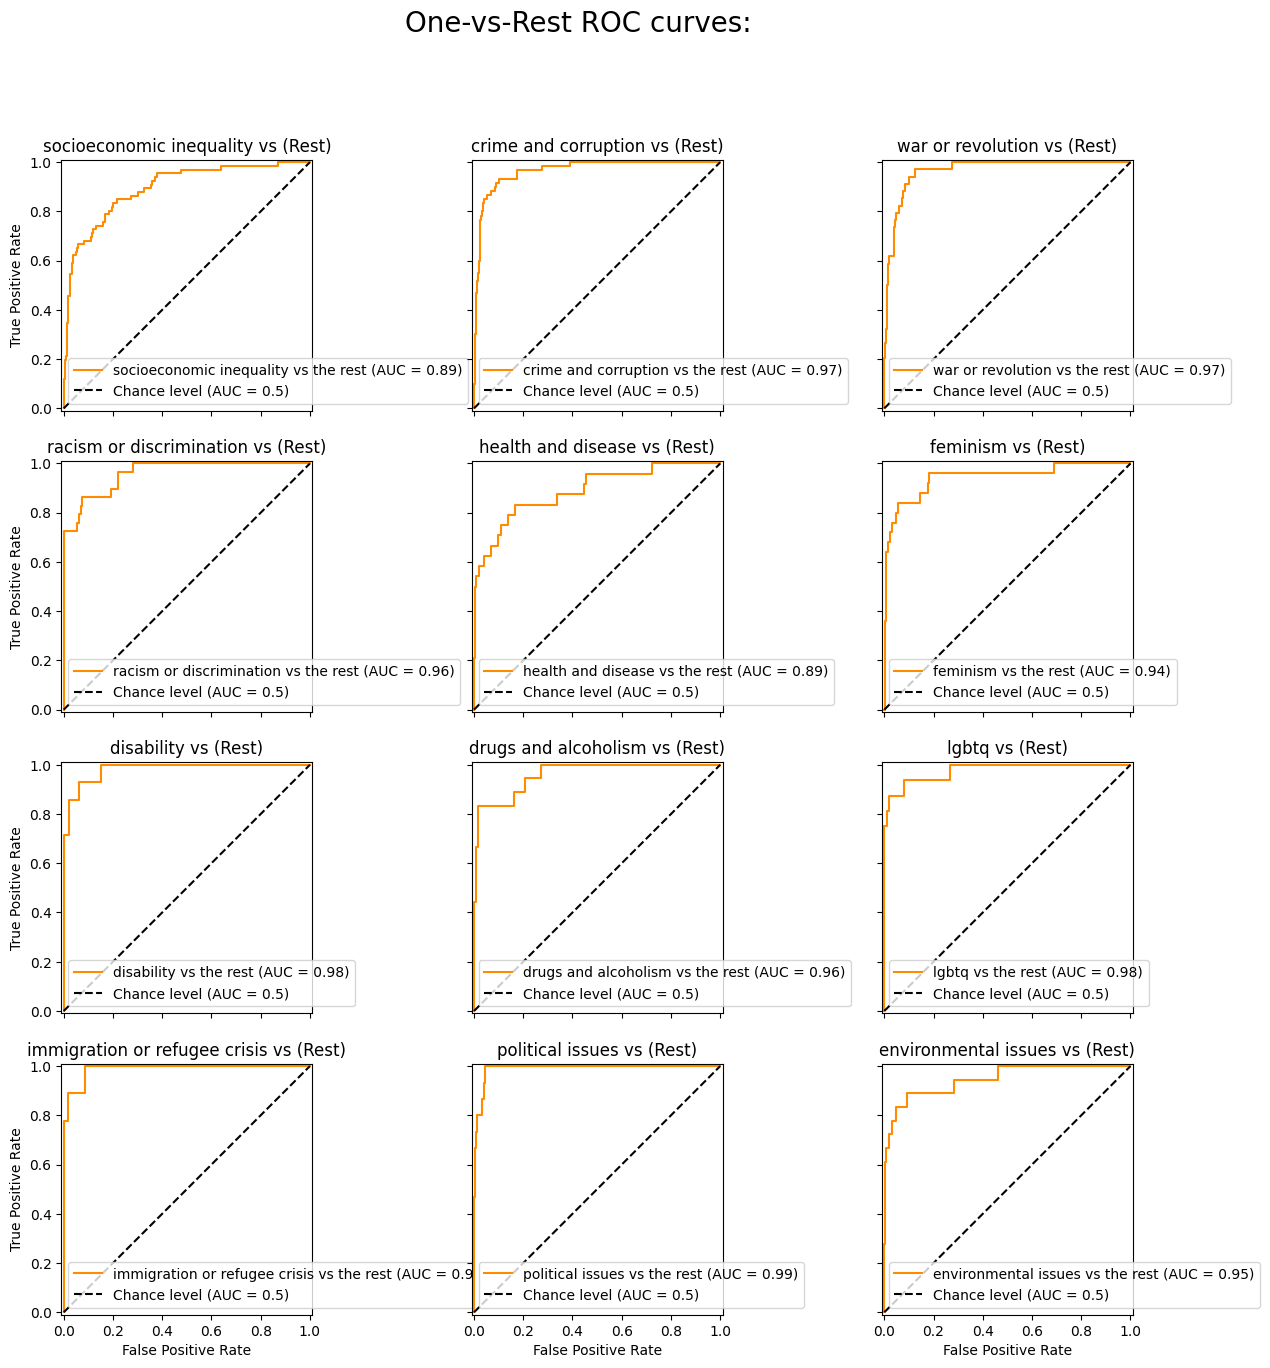

In [80]:
fig, ax = plt.subplots(4, 3,figsize=(15, 15))
fig.suptitle("One-vs-Rest ROC curves:\n",fontsize=20)
row = 0
col = 0
for class_of_interest in class_names:
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    if col == 3:
        col = 0
        row += 1
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
        ax = ax[row,col],
        plot_chance_level=True,
    )
    
    _ = display.ax_.set(
        #xlabel="False Positive Rate",
        #ylabel="True Positive Rate",
        title=f"{class_of_interest} vs (Rest)",
    )
    col+= 1
for a in ax.flat:
    a.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
for a in ax.flat:
    a.label_outer()
    a.legend(loc='lower left')

In [81]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

In [82]:
c_names = ['crime and corruption','disability','drugs and alcoholism','environmental issues','feminism','health and disease',
           'immigration or refugee crisis','lgbtq','others','political issues','racism or discrimination','socioeconomic inequality',
           'war or revolution']

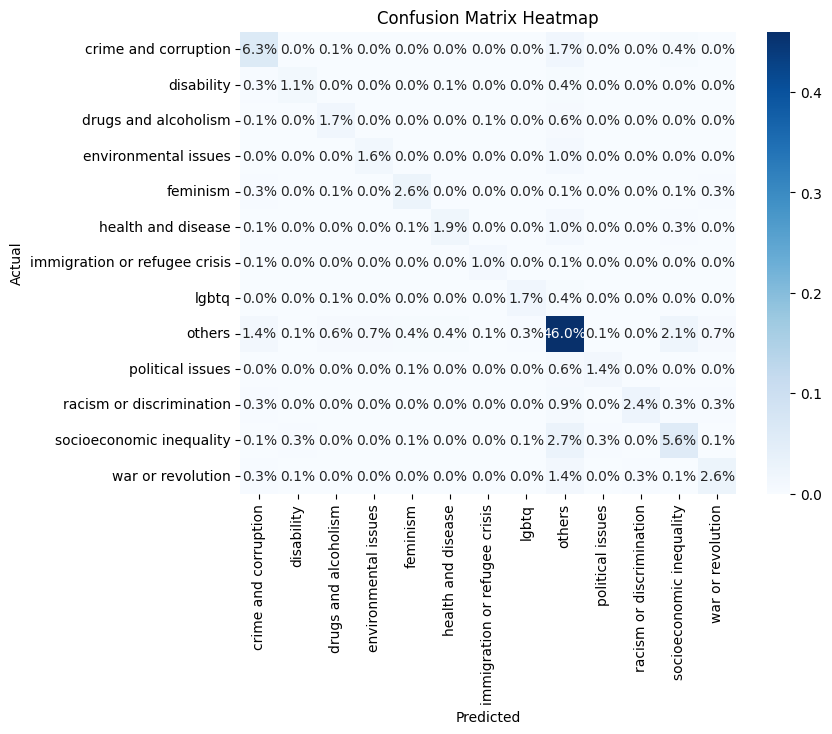

In [83]:
# Plotting the heatmap
plt.figure(figsize=(8,6))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=c_names, yticklabels=c_names)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.1%', cmap='Blues', xticklabels=c_names, yticklabels=c_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

#### Precision-Recall Curves for Multi-Class Classification

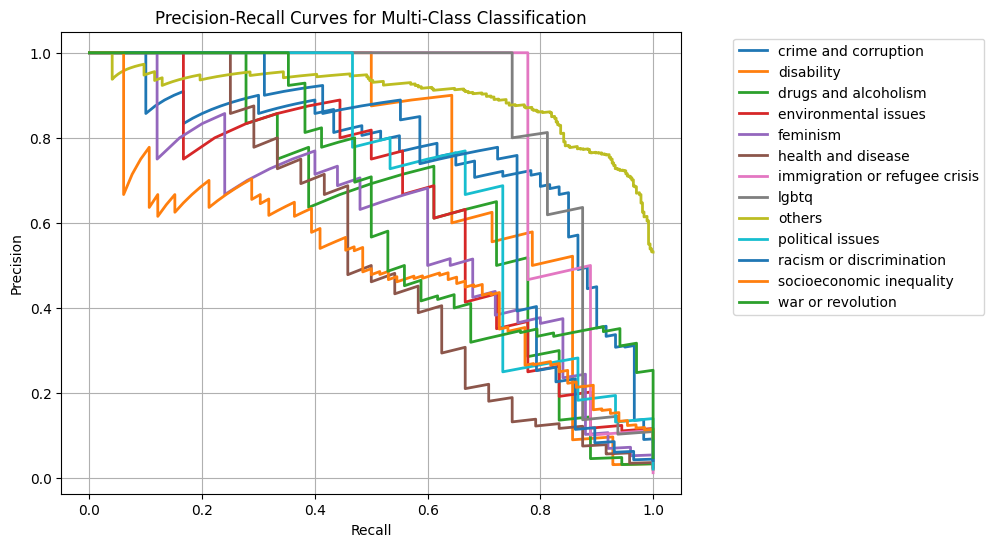

In [84]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


# Train a One-vs-Rest SVM classifier (you can adjust hyperparameters)
classifier = OneVsRestClassifier(best_model)
classifier.fit(X_train_features, label_binarize(y_train, classes=c_names))

# Get precision and recall values for each class
y_score = classifier.decision_function(X_test_features)

# Plot Precision-Recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-Class Classification')
plt.legend(loc='upper right', bbox_to_anchor=(0.5,0.5,1.0, 0.5), labels=c_names)
plt.grid()
plt.show()

## Unlabelled Data prediction

In [34]:
unlabelled_df.head(3)

,summary,film_id,summary_id,sentiment_score,st_embeddings
10,"During the 1980s, a failed stand-up comedian i...",tt7286456,1,-0.9337,"tensor([[ 4.7050e-01, 9.1883e-02, -2.9696e-02..."
11,A socially inept clown for hire - Arthur Fleck...,tt7286456,2,-0.6249,"tensor([[ 7.6473e-02, -1.0007e-01, -1.4372e-01..."
12,Struggling to make people laugh in grim early-...,tt7286456,3,-0.9590,"tensor([[ 1.8248e-01, -3.1203e-02, -1.1097e-01..."


In [35]:
unlabelled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8653 entries, 10 to 8797
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   summary          8653 non-null   object 
 1   film_id          8653 non-null   object 
 2   summary_id       8653 non-null   int64  
 3   sentiment_score  8653 non-null   float64
 4   st_embeddings    8653 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 405.6+ KB


#### Create normalize feartures for unlabelled data

In [36]:
unlabelled_df['st_embeddings'] = unlabelled_df.st_embeddings.progress_apply(lambda x: F.normalize(eval("torch." + x), p=2, dim=1))
X_unlabel_embeddings = np.vstack(unlabelled_df['st_embeddings'].values)

  0%|          | 0/8653 [00:00<?, ?it/s]

C:\Users\lovke\AppData\Local\Temp\ipykernel_35940\3655185616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabelled_df['st_embeddings'] = unlabelled_df.st_embeddings.progress_apply(lambda x: F.normalize(eval("torch." + x), p=2, dim=1))


#### Normalize sentiment score between [0,1]

In [37]:
sentiment_unlabel_scaled = scaler.fit_transform(unlabelled_df['sentiment_score'].to_numpy().reshape(-1, 1))

In [38]:
X_unlabel_features = np.column_stack((X_unlabel_embeddings, sentiment_unlabel_scaled))
X_unlabel_features.shape

(8653, 385)

In [273]:
pseudo_labels = best_model.predict(X_unlabel_features)

In [278]:
unlabelled_df['predicted_values'] = pseudo_labels
unlabelled_df.head(3)

,summary,film_id,summary_id,sentiment,sentiment_score,summary_len,st_embeddings,predicted_values
0,"Over the course of several years, two convicts...",tt0111161,1,Positive,0.7096,19,"[[tensor(0.0594), tensor(-0.0302), tensor(-0.2...",crime and corruption
1,Chronicles the experiences of a formerly succe...,tt0111161,2,Negative,-0.8959,60,"[[tensor(0.0062), tensor(-0.1834), tensor(-0.4...",socioeconomic inequality
2,When an innocent male banker is sent to prison...,tt0111161,3,Negative,-0.5859,47,"[[tensor(0.1302), tensor(0.0726), tensor(-0.32...",crime and corruption


#### write the predicted values of unlabelled data onto file

In [280]:
unlabelled_df.to_csv(os.path.join(os.path.dirname(__name__), "DataFiles\\unlabelled_predicted_sample_dataset.tsv"), sep='\t', index=False)

#### Refine the predictions per film and generate final label as per highest count

In [67]:
filename = os.path.join(os.path.dirname(__name__), "DataFiles\\unlabelled_predicted_sample_dataset.tsv")
unlabelled_df = pd.read_csv(filename,delimiter='\t',low_memory=False)

In [48]:
predicted_data = unlabelled_df.groupby(['film_id']).agg({"predicted_values": ['count',  ', '.join]}).reset_index()
predicted_data.columns = [col[0] if col[-1]=='' else col[-1] for col in predicted_data.columns.values]
predicted_data.rename(columns={'join': 'predicted_values', 'count': 'pred_count'}, inplace = True)
print(len(predicted_data))
predicted_data.head(3)

4904


,film_id,pred_count,predicted_values
0,tt0000147,2,"others, others"
1,tt0002423,1,feminism
2,tt0003740,3,"political issues, others, feminism"


In [49]:
issue_list = ['crime and corruption', 'disability', 'drugs and alcoholism', 'environmental issues', 'feminism',
                     'health and disease', 'immigration or refugee crisis', 'lgbtq', 'political issues', 
                     'racism or discrimination', 'socioeconomic inequality', 'war or revolution']

def generate_label(x):
    
    issue_dict={}
    issue_list = []
    x_list = x.split(",")
    for issue in x_list:
        if issue.strip() in issue_list:
            issue_dict[issue.strip()] += 1
        else:
            issue_list.append(issue.strip())
            issue_dict[issue.strip()] = 1

    if issue_dict:
        sorted_issues = dict(sorted(issue_dict.items(), key=lambda x:x[1], reverse=True))
        top_label = list(sorted_issues.keys())[0]

        return sorted_issues, top_label
    else:
        return 'None', 'others'


In [50]:
predicted_data[['sorted_labels','final_label']] = predicted_data['predicted_values'].progress_apply(lambda x: generate_label(x)).to_list()
predicted_data.head(3)

  0%|          | 0/4904 [00:00<?, ?it/s]

,film_id,pred_count,predicted_values,sorted_labels,final_label
0,tt0000147,2,"others, others",{'others': 2},others
1,tt0002423,1,feminism,{'feminism': 1},feminism
2,tt0003740,3,"political issues, others, feminism","{'political issues': 1, 'others': 1, 'feminism...",political issues


#### Combine unlabelled and labelled dataset

In [51]:
target.rename(columns={'manual_label': 'issue_label'}, inplace = True)
target.head(3)

,film_id,issue_label
0,tt0120737,others
1,tt0114369,crime and corruption
2,tt0482571,crime and corruption


In [53]:
unlabel_target = predicted_data[['film_id','final_label']]
unlabel_target.rename(columns={'final_label': 'issue_label'}, inplace = True)
unlabel_target.head(3)

C:\Users\lovke\AppData\Local\Temp\ipykernel_35940\836799271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabel_target.rename(columns={'final_label': 'issue_label'}, inplace = True)


,film_id,issue_label
0,tt0000147,others
1,tt0002423,feminism
2,tt0003740,political issues


In [57]:
final_target = pd.concat([target, unlabel_target], axis=0)
final_target['issue_label'] = final_target['issue_label'].progress_apply(lambda x: (x.lower().strip()))
print(len(final_target))
final_target.issue_label.value_counts()

  0%|          | 0/5904 [00:00<?, ?it/s]

5904


others                           3844
socioeconomic inequality          531
crime and corruption              487
war or revolution                 249
racism or discrimination          197
feminism                          172
drugs and alcoholism              106
lgbtq                              75
health and disease                 70
disability                         56
immigration or refugee crisis      42
environmental issues               40
political issues                   35
Name: issue_label, dtype: int64

In [58]:
final_target.to_csv(os.path.join(os.path.dirname(__name__), "DataFiles\Final_predicted_sample_dataset.tsv"), sep='\t', index=False)

#### Create full feature dataaset

In [61]:
filename = os.path.join(os.path.dirname(__name__), "DataFiles\\film_exploration.tsv")
basics_df = pd.read_csv(filename,delimiter='\t',low_memory=False)
#basics_df.rename(columns={'tconst': 'film_id'}, inplace = True)
basics_df.head(3)

,openingWeekend,film_id,weekendEarning,budget,GrossUSCanada,GrossWorldwide,officialSitesCount,officialSites,productionCompanyCount,productionCompanies,...,genres,budget_est,budget_label,coo_list,genre_list,coo_continent,decades,film_era,country,continent
0,NaN,tt0000147,0.0,0,0.0,0.0,0.0,NaN,1.0,Veriscope Company,...,"Documentary,News,Sport",0.0,NaN,United States,Documentary,North America,"(1960, 1970]",New Hollywood Era,United States,North America
1,NaN,tt0000147,0.0,0,0.0,0.0,0.0,NaN,1.0,Veriscope Company,...,"Documentary,News,Sport",0.0,NaN,United States,News,North America,"(1960, 1970]",New Hollywood Era,United States,North America
2,NaN,tt0000147,0.0,0,0.0,0.0,0.0,NaN,1.0,Veriscope Company,...,"Documentary,News,Sport",0.0,NaN,United States,Sport,North America,"(1960, 1970]",New Hollywood Era,United States,North America


In [62]:
final_target = pd.merge(final_target, basics_df, how="left", on=["film_id"])

In [64]:
unwanted_movies = ['tt15477076', 'tt0245936', 'tt15039908', 'tt0118656', 'tt0463670',
                  'tt1606306', 'tt1298820', 'tt21441286', 'tt0487456', 'tt2536522', 'tt15698592', 'tt5910170','tt0081299']

def remove_extra(df, unwanted_movies):
    indexfilms = df[df['film_id'].isin(unwanted_movies)].index
    df.drop(indexfilms, inplace=True)

remove_extra(final_target, unwanted_movies)

In [66]:
final_target.to_csv(os.path.join(os.path.dirname(__name__), "DataFiles\Final_sample_dataset.tsv"), sep='\t', index=False)